In [227]:
# import the necessary packages
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
from skimage.morphology import erosion, dilation, opening, closing
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image
from IPython.display import Image as IPImage, display


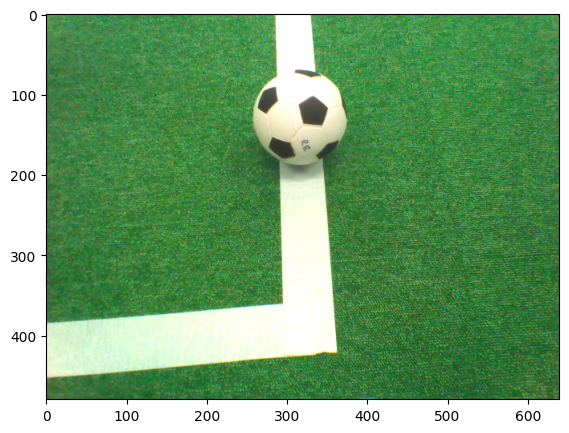

In [228]:
image_path = 'alfie_lm_ball_line0001.png' 
frame = cv2.imread(image_path)


frame_copy =frame.copy()
frame_copy2 =frame.copy()



#Visualize function
def visualize(image, gray = False, hsv_rep = False):
    plt.figure(figsize=(10, 5))

    if hsv_rep and not gray:
        img = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        plt.imshow(img) 

    elif not hsv_rep and gray:
        plt.imshow(image, cmap='gray')

    else:
        plt.imshow(image) 

    plt.show()

frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
visualize(frame)

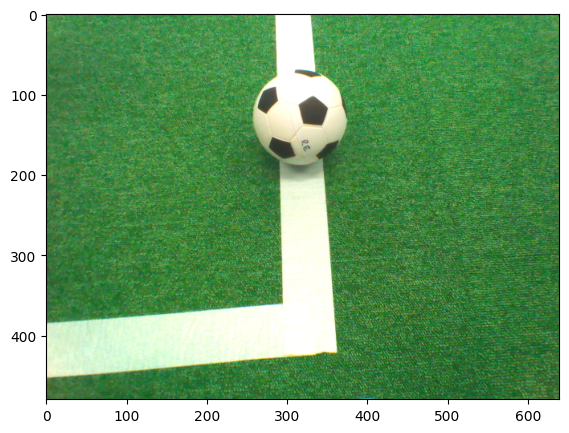

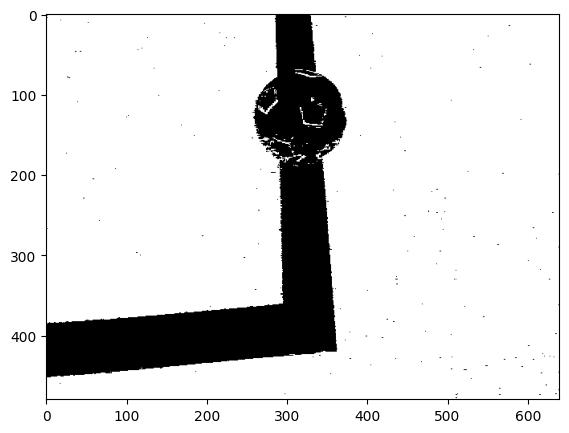

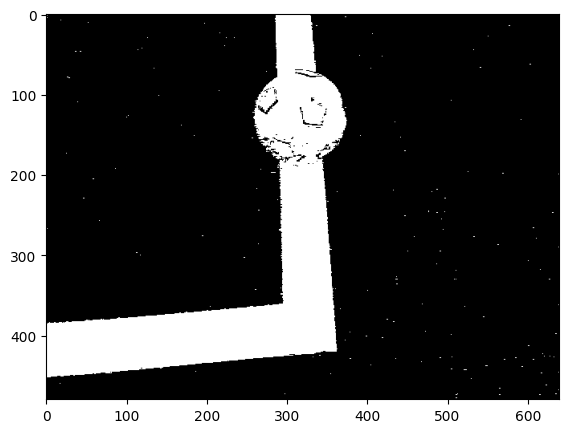

In [229]:
# To select black, white and gray values it chooses values with a low saturation
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
visualize(hsv, hsv_rep = True)

threshold_value = 70 #param
_, mask_inv = cv2.threshold(hsv[:, :, 1], threshold_value, 255, cv2.THRESH_BINARY)

visualize(mask_inv, gray=True)
mask =cv2.bitwise_not(mask_inv)
visualize(mask, gray=True)



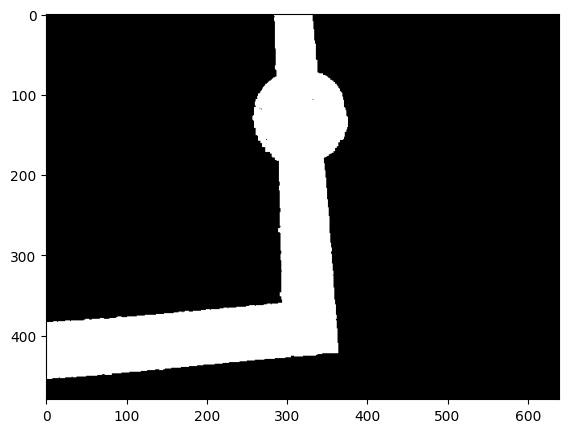

In [230]:
#This is what the dude did
iterat_erode = 1
k_erode = 2
kernel_erode = np.ones((k_erode, k_erode), np.uint8)

iterat_dilate = 1
k_dilate = 5
kernel_dilate = np.ones((k_dilate, k_dilate), np.uint8)

mask1 = cv2.erode(mask, kernel_erode, iterat_erode) #param
mask2 = cv2.dilate(mask1, kernel_dilate, iterat_dilate) #param

visualize(mask2, gray = True)

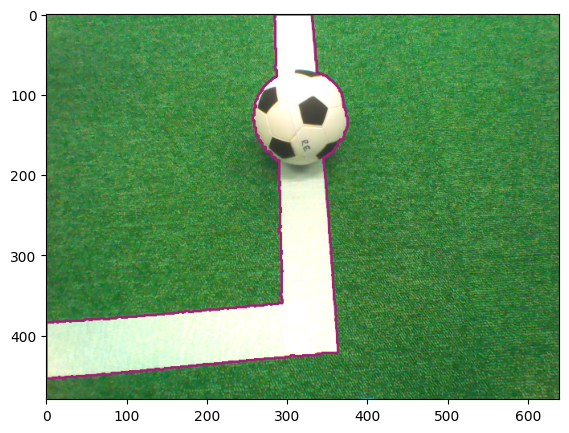

In [231]:
# find contours in the mask and initialize the current
mask = mask2
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
center = None

for c in cnts:
    cv2.drawContours(frame, [c], -1, (160, 34, 119), 2)

visualize(frame)

In [232]:
def calculate_curvature4(contour):
    # Convert contour to numpy array
    contour_array = np.array(contour)

    # Extract x and y coordinates
    x = contour_array[:, 0, 0]
    y = contour_array[:, 0, 1]

    # Calculate curvature
    if len(x) >= 3:  # Ensure there are at least 3 points for gradient calculation
        dx = np.gradient(x, edge_order=1)
        dy = np.gradient(y, edge_order=1)

        # Calculate second derivatives
        d2x = np.gradient(dx, edge_order=1)
        d2y = np.gradient(dy, edge_order=1)

        # Calculate curvature
        curvature = np.abs(dx * d2y - dy * d2x) / (dx**2 + dy**2)**(3/2)

        return curvature
    else:
        return np.zeros(len(x))


len_segments = 40 #param
circular_limit = 0.35 #param


def compute_circularity(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = 4 * np.pi * area / (perimeter * perimeter)
    return circularity

def calculate_curvature3(segment):
    # Get points
    length = len(segment)

    if length == 0:
        return 0.0
    
    x0, y0 = segment[0][0][0], segment[0][0][1]   #[num][0 always][o], o=0 is x and o=1 is
    xm, ym = segment[length//5][0][0], segment[length//5][0][1]
    slopes = np.zeros(4)
    sum = 0

    for i in range(1, 5):   #5 points and 4 slopes
        xm, ym = segment[i*length//5][0][0], segment[i*length//5][0][1]
        slope = (ym-y0) / (xm-x0)
        slopes[i-1] = slope   
        sum += slope
        x0, y0 = xm, ym

    mean_value = sum / 4
    sum_of_diff = (slopes[0] - mean_value) + (slopes[1] - mean_value) + (slopes[2] - mean_value) + (slopes[3] - mean_value) 

    return sum_of_diff

def divide_contour_into_segments(contour):
    # Calculate the total length of the contour
    total_length = cv2.arcLength(contour, closed=True)
    
    # Calculate the length of each segment depending on the contour circularity
    circularity = compute_circularity(contour)
    print('circularity', circularity)
    if abs(circularity - 1) < circular_limit:
        num_segments = 4
    else:
        num_segments = int(total_length/len_segments)

        
    segment_length = total_length / num_segments
    
    segments = []
    start_idx = 0

    # Divide the contour into segments
    for i in range(num_segments):
        #end_idx = int((i + 1) * len(contour) / num_segments)
        end_idx = int(i * len(contour) / num_segments + segment_length)
        segment = contour[start_idx:end_idx]
        segments.append(segment)
        start_idx = end_idx
    
    return segments


def divide_contour_into_segments2(contour, threshold_slope=2):
    segments = []
    current_segment = []

    for i in range(1, len(contour)):
        # Ensure each point has both x and y coordinates
        if len(contour[i]) != 2 or len(contour[i-1]) != 2:
            continue

        # Calculate slope between consecutive points
        slope = (contour[i][1] - contour[i-1][1]) / (contour[i][0] - contour[i-1][0])

        # Check if the absolute change in slope (tangent of the angle change) is greater than the threshold
        if abs(np.arctan(slope)) > threshold_slope:
            # Start a new segment
            if current_segment:
                segments.append(np.array(current_segment))
            current_segment = [contour[i-1], contour[i]]
        else:
            # Continue the current segment
            current_segment.append(contour[i])

    # Add the last segment
    if current_segment:
        segments.append(np.array(current_segment))

    return segments

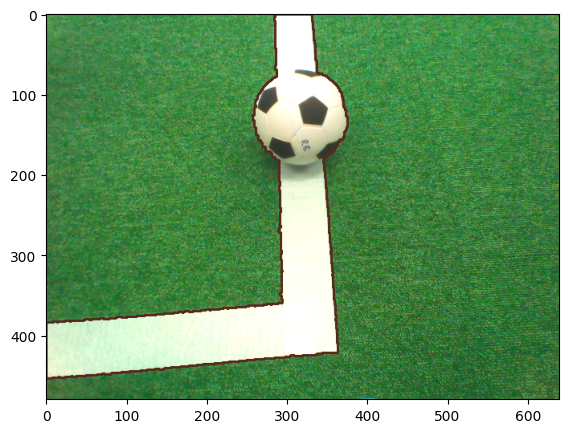

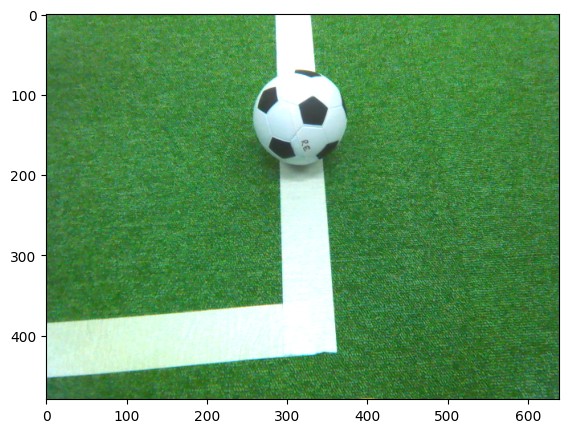

In [233]:
#NEW MODEL WORKING WITH SEGMENTATION AND EVERYTHING LALALA
areamax = 100000 #param
areamin = 785 #param


circles = []
for contour in cnts:
			#parameters to see how circular it is 
			area = cv2.contourArea(contour)
			perimeter = cv2.arcLength(contour, True)
			#parameters to make sure there is black inside the contour:
			threshold_black_value = 125 #param
			_, mask_inv = cv2.threshold(frame[:, :, 2], threshold_black_value, 255, cv2.THRESH_BINARY_INV)


			# Check if there are dark gray pixels inside the filled contours

			if int(area) != 0  and ( np.any(frame[:, :, 2][contour[:, :, 1], contour[:, :, 0]] < threshold_black_value) ) and  areamax > area> areamin: # Perimeter to avoid divide by 0, and area so it doesn't choose small circles
				circularity = 4 * np.pi * area / (perimeter * perimeter)
				cv2.drawContours(frame, [contour], -1, (87, 40, 30), 2)	  #cv2.drawContours can only be used for closed contours
				#print("perimeter", perimeter)

				#Segmentation of contours
				segments = divide_contour_into_segments2(contour)
				old_index = 9999

				cont = False

				for i, segment in enumerate(segments):
				#for i in range(30, 35):
					#segment = segments[i]
					
					color = np.random.randint(0, 255, size=3)  # Generate a random color
					color = tuple(map(int, color))


					curvature = calculate_curvature4(segment)
					print(curvature)
					if any(abs(curvature) > 1.3):  # param
				
						print(curvature)
						#print('curvature:', curvature)
						#cv2.polylines(frame, [segment], isClosed=False, thickness= 2, color=(70, 218, 40))

						if old_index == i-1: #Some of the segments of the large segment
							large_segment = np.concatenate((old_segment, segment ))
							cv2.polylines(frame, [large_segment], isClosed=False, thickness= 2, color=(255, 0, 0)) #red
							old_segment = large_segment
							cont = True #the large_segment still being increased

						else: #it is the first segment of a large_segment
							old_segment = segment
													
						old_index = i

					

					elif (old_index != i-1 and cont) or (i == len(segments)-1 and cont): #means that is the fisrt segment that is not in the large segment
							area = cv2.contourArea(large_segment)
							perimeter = cv2.arcLength(large_segment, True)
							print("perimeter", perimeter)
							circularity = 4 * np.pi * area / (perimeter * perimeter)
							circularity = compute_circularity(large_segment)
							circles.append((large_segment, circularity))							
							old_segment = segment
							cont = False
			
					cv2.polylines(frame_copy, [segment], isClosed=False, thickness= 2, color=color)
					
visualize(frame)
visualize(frame_copy)

In [234]:
# Choose the contour with the highest circularity
circles.sort(key=lambda x: abs(x[1] - 1))  # Sort by circularity closest to 1
best_circle = circles[0][0]  # Select the contour with closest circularity to 1
print("best", cv2.contourArea(best_circle))

# Draw the chosen contour
#cv2.drawContours(frame, [best_circle], -1, (0, 0, 255), 2) #blue
print(best_circle)

IndexError: list index out of range

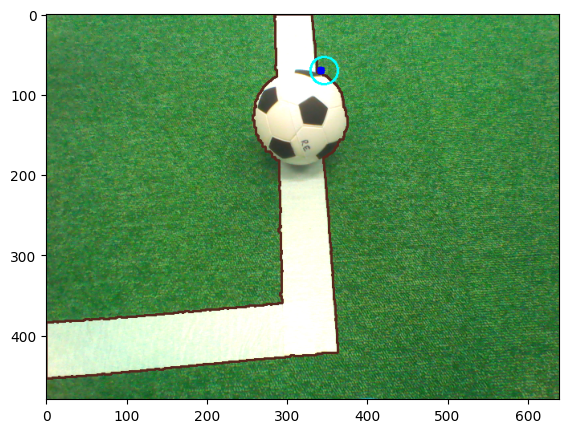

In [235]:
((x, y), radius) = cv2.minEnclosingCircle(best_circle)
M = cv2.moments(best_circle)
center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
# only proceed if the radius meets a minimum size. Usefull when there is a long segment too short
radius_limit = 0 #param

if radius > radius_limit:
    # draw the circle and centroid on the frame,
    # then update the list of tracked points
    cv2.circle(frame, (int(x), int(y)), int(radius),
        (0, 255, 255), 2)
    cv2.circle(frame, center, 5, (0, 0, 255), -1)

visualize(frame)